# Introduction au Challenge  

L’objectif de ce projet est de classifier un dataset de champignons en trois classes : `amanita`, `oyster` et `crimini`. Pour cela, nous avons d'abord commencé par analyser visuellement les images afin de mieux comprendre leurs caractéristiques et de déterminer quel réseau de neurones serait le plus adapté à notre problème. Ensuite, nous avons étudié différents articles scientifiques traitant de la classification d'images avec des dimensions variées. Sur cette base, nous avons décidé  de tester deux modèles de réseaux de neurones préentraînés et de les adapter à notre jeu de données.

Le premier modèle testé était **Inception-V3**, et nous a permet d'obtenir  d'excellents résultats avec une précision de `95 %` sur les données de test et 99 % sur l'ensemble d'entraînement. Nous avons réalisé plusieurs tests avec ce réseau pour optimiser les hyperparamètres, ce qui a renforcé ses performances. Dans un deuxième temps, nous avons évalué le réseau **VGG-16** sur notre dataset. Cependant, les résultats obtenus étaient décevants, ce qui nous a poussés à abandonner ce modèle et à concentrer nos efforts sur Inception.

Un défi majeur auquel nous avons été confrontés était lié aux limitations de Google Colab, où la durée d’entraînement sur GPU était restreinte à deux heures. Pour contourner ce problème, nous avons dû créer plusieurs environnements Colab pour poursuivre les tests. Cependant, l'entraînement sur CPU s’est avéré très lent, avec une époque prenant plus de 10 minutes. Malgré ces contraintes, nous avons réussi à optimiser et valider nos modèles, en nous focalisant sur le réseau Inception, qui a montré des performances prometteuses pour notre tâche de classification.

##Bibliothèques
 Cette partie sert à importer les bibliothèques essentielles pour la manipulation des fichiers, la visualisation les données, et la création des modèles de machine learning.

**Le choix de TensorFlow a été basé sur une préférence et une familiarité personnelle**




In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##Chargement des Images depuis Google Drive

Cette section permet de:


*   Monter Google Drive
*   Extraire et charger les données d'images depuis un fichier ZIP
*   Analyser la répartition des données en classes, et de visualiser un échantillon aléatoire pour exploration




In [ ]:
# Monter Google Drive dans l'environnement Colab pour accéder aux fichiers directement
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Classes: ['oyster', 'amanita', 'crimini']
Nombre d'images total: 1643
Nombre d'images par classes: [547, 535, 561]


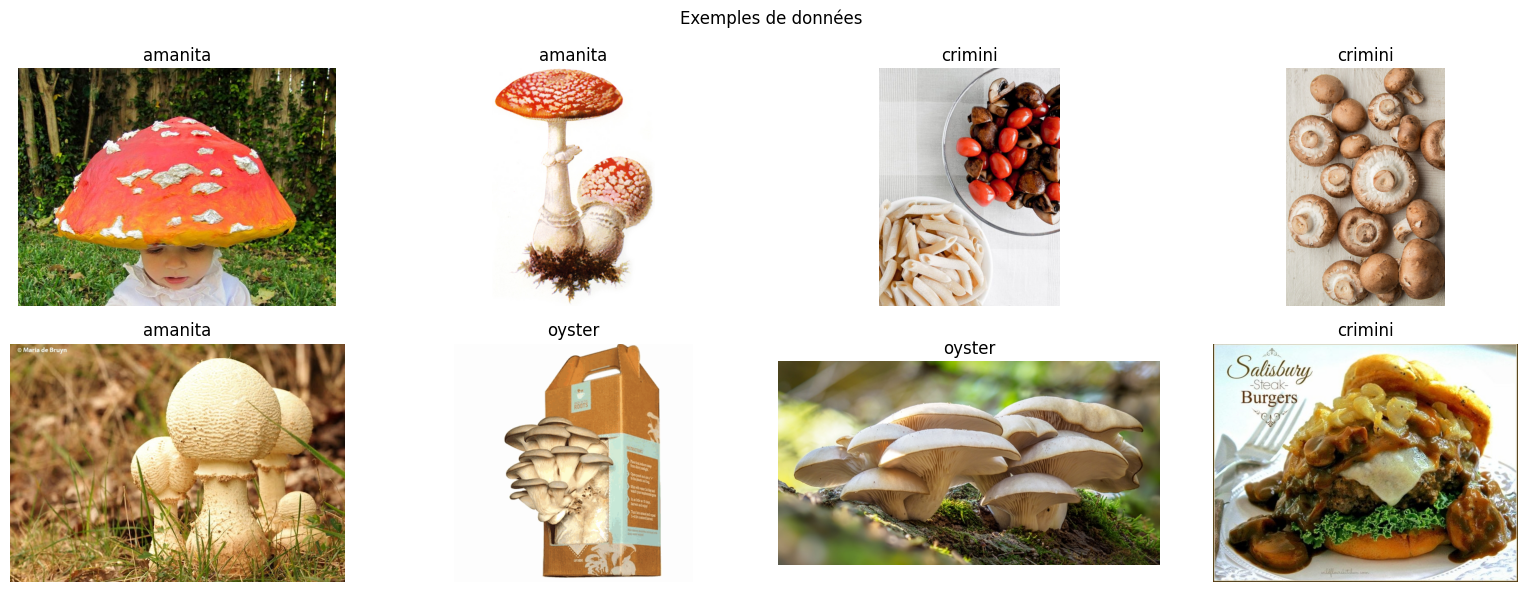

In [ ]:

#############################-- La fonction Data() permet d'extraire, charger et analyser les données depuis un fichier zip --############################

def Data():
    # Extraction du fichier ZIP
    with zipfile.ZipFile('/content/drive/MyDrive/challenge_rendu_26_janvier/mushrooms.zip', 'r') as zip:
        zip.extractall('./datasets')

    data_dir = os.path.join("datasets","mushrooms") # Définir le chemin vers le répertoire des données extraites
    classes = os.listdir(data_dir) # Lister les sous-dossiers, chaque sous-dossier représente une classe
    print("Classes:", classes) # Afficher les noms des classes

    # Préparer une liste contenant les chemins des images et leurs étiquettes
    data_list = []
    for label in classes:
        image_files = os.listdir(os.path.join(data_dir,label)) # Liste des images dans chaque classe
        data_list.extend([(label,os.path.join(data_dir,label,f)) for f in image_files]) # Ajouter les tuples (classe, chemin d'image) à data_list

    # Afficher des informations sur les données
    print("Nombre d'images total:",len(data_list)) # Nombre total d'images
    print("Nombre d'images par classes:",[len(os.listdir(os.path.join(data_dir,label))) for label in classes]) # Nombre total d'images pour chaque classe

    return data_list # Retourne la liste contenant les données

##########################################################################################################################################################


data_list = Data() # Appel de la Data() pour charger les données
image_samples = np.random.randint(0,high=len(data_list)-1, size=8) # Sélection aléatoire d'exemples d'images


# Visualisation des exemples d'images
fig = plt.figure(figsize=(16, 6))
for i, img_idx in enumerate(image_samples):
    axs = fig.add_subplot(2, 4, i + 1)
    axs.set_title(data_list[img_idx][0])
    image = Image.open(data_list[img_idx][1])
    plt.imshow(image)
    plt.axis('off')


# Ajoute un titre général à la figure et ajuste la mise en page
plt.suptitle("Exemples de données")
plt.tight_layout()

Nous avons cherché dans un premier temps à évaluer si toutes les images pouvaient être redimensionnées à une taille unique en prenant la plus petite taille d'image comme référence. Pour ce faire, nous avons identifié l'image ayant les dimensions minimales et avons réduit toutes les autres images à ces dimensions. L'objectif était de préparer les données pour les passer dans un réseau de neurones convolutionnel (CNN), comme vu en cours.

Cependant, comme le montrent les exemples ci-dessous, réduire les grandes images à la taille de la plus petite image entraîne une dégradation significative de leur qualité. Cette dégradation se manifeste par l'apparition de bruit et une perte de détails visuels importants. Ces observations nous ont conduit à rejeter cette méthode de prétraitement, car elle pourrait nuire à la performance du modèle en réduisant la qualité des données d'entrée.

Les deux sections suivantes permettent d'implémenter ce processus qui sera finalement abandonné par la suite.

##Identification et Visualisation des Images aux Dimensions Extrêmes

Cette section identifie les images ayant les dimensions minimales et maximales (hauteur et largeur) dans notre dataset.

Les résultats sont ensuite visualisés.

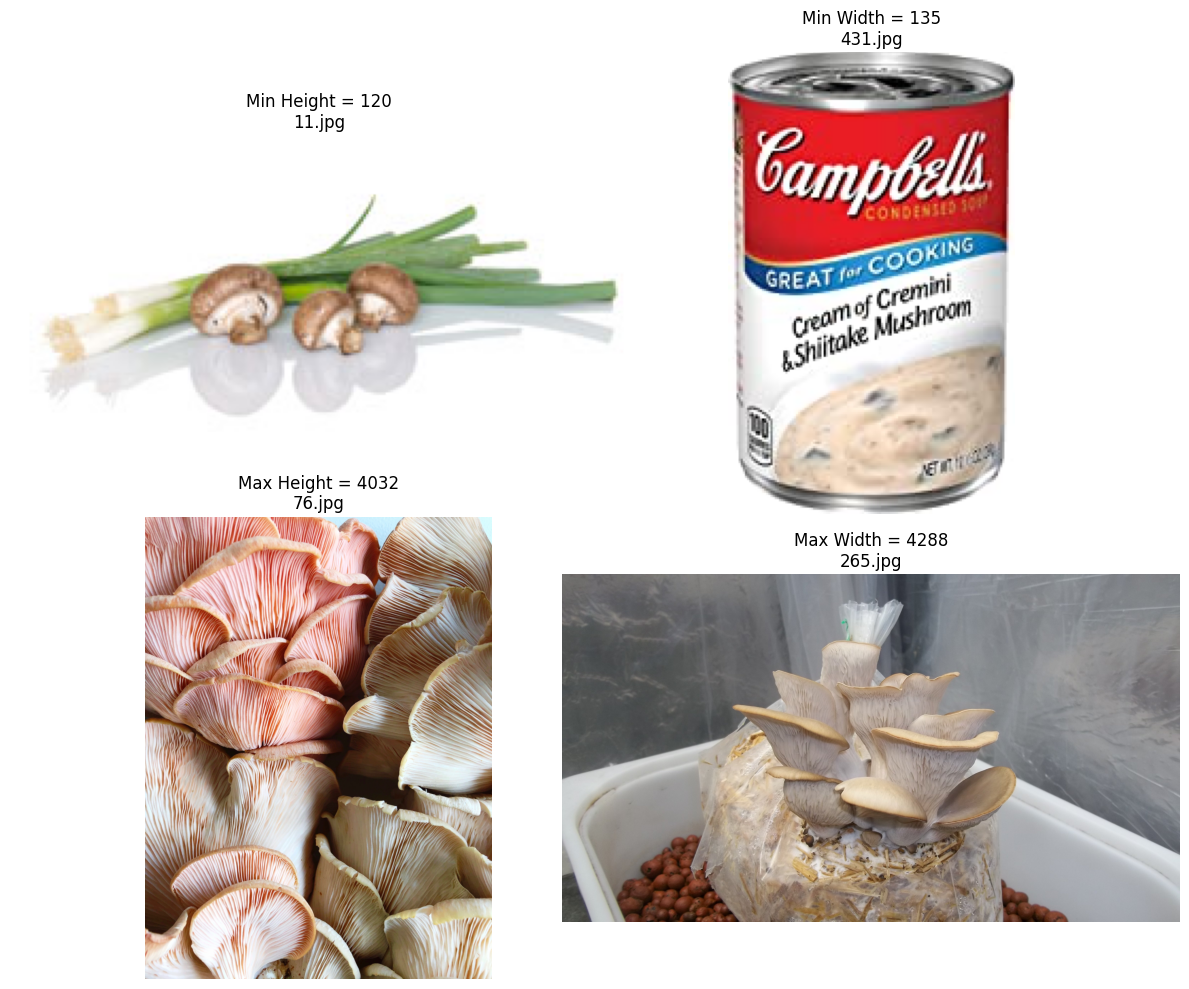

In [ ]:
#################################################-- find_extreme_images() identifie les images ayant les dimensions extrêmes --#################################################
# min_height : (chemin_image, hauteur_minimale)
# min_width  : (chemin_image, largeur_minimale)
# max_height : (chemin_image, hauteur_maximale)
# max_width  : (chemin_image, largeur_maximale)
# NB: Si plusieurs images ont la même hauteur ou largeur minimale, seule la première rencontrée est conservée.

def find_extreme_images(data_list):

    # Initialisation des variables pour les dimensions extrêmes
    min_height_img_path = None
    min_height_value = float('inf') # Valeur infinie pour initialiser la comparaison

    min_width_img_path = None
    min_width_value = float('inf')

    max_height_img_path = None
    max_height_value = 0 # Valeur 0 pour initialiser la comparaison

    max_width_img_path = None
    max_width_value = 0

    # Parcours de toutes les images dans la liste des données
    for label, img_path in data_list:
        with Image.open(img_path) as img: # Ouverture de l'image
            width, height = img.size  # Récupération des dimensions (largeur, hauteur)

            # Mise à jour de la hauteur minimale
            if height < min_height_value:
                min_height_value = height
                min_height_img_path = img_path

            # Mise à jour de la largeur minimale
            if width < min_width_value:
                min_width_value = width
                min_width_img_path = img_path

            # Mise à jour de la hauteur maximale
            if height > max_height_value:
                max_height_value = height
                max_height_img_path = img_path

            # Mise à jour de la largeur maximale
            if width > max_width_value:
                max_width_value = width
                max_width_img_path = img_path

    # Retour du dictionnaire contenant les images extrêmes et leurs dimensions
    return {
        'min_height': (min_height_img_path, min_height_value),
        'min_width':  (min_width_img_path,  min_width_value),
        'max_height': (max_height_img_path, max_height_value),
        'max_width':  (max_width_img_path,  max_width_value)
    }

##################################################################################################################################################################################


# Exemple d'utilisation de la fonction
extremes = find_extreme_images(data_list)


# Extraction des chemins et valeurs des images extrêmes
min_height_path, min_h = extremes['min_height']
min_width_path,  min_w = extremes['min_width']
max_height_path, max_h = extremes['max_height']
max_width_path,  max_w = extremes['max_width']


# Affichage des 4 images extrêmes:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Image avec la hauteur minimale
axs[0, 0].imshow(Image.open(min_height_path))
axs[0, 0].set_title(f"Min Height = {min_h}\n{os.path.basename(min_height_path)}")
axs[0, 0].axis('off')

# Image avec la largeur minimale
axs[0, 1].imshow(Image.open(min_width_path))
axs[0, 1].set_title(f"Min Width = {min_w}\n{os.path.basename(min_width_path)}")
axs[0, 1].axis('off')

# Image avec la hauteur maximale
axs[1, 0].imshow(Image.open(max_height_path))
axs[1, 0].set_title(f"Max Height = {max_h}\n{os.path.basename(max_height_path)}")
axs[1, 0].axis('off')

# Image avec la largeur maximale
axs[1, 1].imshow(Image.open(max_width_path))
axs[1, 1].set_title(f"Max Width = {max_w}\n{os.path.basename(max_width_path)}")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


## Test de redimensionnement des images
Cette section redimensionne l'image la plus grande pour correspondre aux dimensions de la plus petite image, afin d'observer les différences visuelles après réduction.

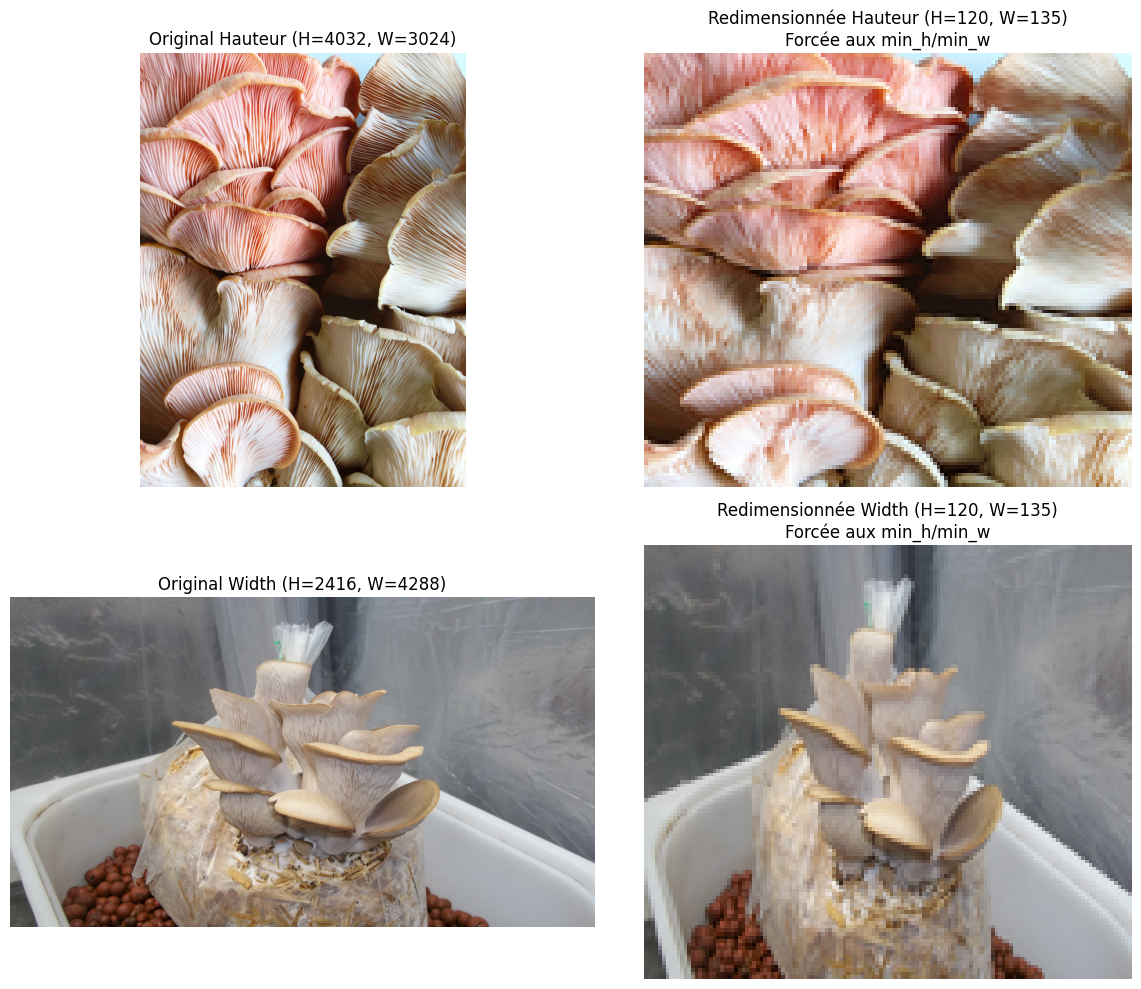

In [ ]:
# Chargement des images avec les dimensions maximales
img_max_h = Image.open(max_height_path)
img_max_w = Image.open(max_width_path)

# Redimensionnement des images pour correspondre aux dimensions minimales (min_h et min_w)
resized_fixed_h = img_max_h.resize((min_w, min_h), Image.LANCZOS)
resized_fixed_w = img_max_w.resize((min_w, min_h), Image.LANCZOS)


fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Affichage de l'image originale avec la hauteur maximale
axs[0, 0].imshow(img_max_h)
axs[0, 0].set_title(f"Original Hauteur (H={img_max_h.size[1]}, W={img_max_h.size[0]})")
axs[0, 0].axis('off')

# Affichage de l'image redimensionnée (hauteur maximale réduite à min_h et min_w)
axs[0, 1].imshow(resized_fixed_h)
axs[0, 1].set_title(f"Redimensionnée Hauteur (H={resized_fixed_h.size[1]}, W={resized_fixed_h.size[0]})\nForcée aux min_h/min_w")
axs[0, 1].axis('off')

# Affichage de l'image originale avec la largeur maximale
axs[1, 0].imshow(img_max_w)
axs[1, 0].set_title(f"Original Width (H={img_max_w.size[1]}, W={img_max_w.size[0]})")
axs[1, 0].axis('off')

# Affichage de l'image redimensionnée (largeur maximale réduite à min_h et min_w)
axs[1, 1].imshow(resized_fixed_w)
axs[1, 1].set_title(f"Redimensionnée Width (H={resized_fixed_w.size[1]}, W={resized_fixed_w.size[0]})\nForcée aux min_h/min_w")

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Discussion et démarche à suivre
Comme mentionné précédemment, il est risqué pour la classification de simplement redimensionner toutes les images à la plus petite taille disponible (min\_w, min\_h). Ce procédé peut entraîner **une perte significative d'information visuelle** et rendre certaines images trop **floues,** ce qui dégrade la qualité des données d'entrée pour le modèle.

Afin de mieux comprendre ce problème, nous avons consulté plusieurs articles de référence qui ont traité le cas des images de tailles variables. En nous appuyant également sur les concepts abordés en cours, nous avons décidé de tester deux modèles préentraînés qui ont démontré une forte robustesse pour des tâches similaires : *Inception-V3* et *VGG-16.* Ces modèles sont connus pour leur capacité à bien gérer des images de dimensions diverses grâce à leurs architectures adaptées.


1. **Going Deeper with Convolutions (Inception)**  
   Christian Szegedy, Wei Liu, Yangqing Jia, et al. (2015)  
   [\[arXiv:1409.4842\]](https://arxiv.org/abs/1409.4842) ( avec ImageNet, ils ont réussi à atteigner environ 78.8 % de précision top-1 et 93.9 % de précision top-5)

2. **Fully Convolutional Networks for Semantic Segmentation**  
   Jonathan Long, Evan Shelhamer, Trevor Darrell (CVPR 2015)  
   [\[arXiv:1411.4038\]](https://arxiv.org/abs/1411.4038)( une précision top-5 de 92.7 % sur ImageNet)


#Division des données en Entraînement, Validation et Test
Avant de développer le modèle, nous avons commencé par séparer les données en trois ensembles distincts : données d'entraînement, données de validation et données de test, que nous avons stockés dans le répertoire `datasplit` de notre Google Drive. Nous avons testé différents pourcentages de répartition (par exemple, 70 % pour l'entraînement, 15 % pour la validation, et 15 % pour le test) et observé des variations significatives en termes de précision sur l'ensemble de validation. Dans certains cas, la précision atteignait 95 %, tandis que dans d'autres configurations, elle chutait à 88 %, ce qui montre l'impact de la répartition des données sur les performances du modèle.

In [ ]:
import os
import random
import shutil

##############################-- split_dataset divise le dataset en sous-ensembles d'entraînement, de validation et de test --######################################

def split_dataset(data_list, base_dir='datasets_split',
                  train_ratio=0.7, val_ratio=0.10, test_ratio=0.20):
    # Récupère la liste des classes depuis data_list
    labels = list(set([item[0] for item in data_list]))

    # S'il existe déjà, on le supprime pour repartir de zéro (prudence !)
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)

    # On crée les sous-répertoires train/val/test pour chaque classe
    for subset in ['train', 'val', 'test']:
        for label in labels:
            os.makedirs(os.path.join(base_dir, subset, label), exist_ok=True)

    # Groupement des chemins d'images par label
    label_to_paths = {label: [] for label in labels}
    for label, path in data_list:
        label_to_paths[label].append(path)

    # Pour chaque label, on mélange et on split
    for label in labels:
        paths = label_to_paths[label]
        random.shuffle(paths)

        train_end = int(train_ratio * len(paths))
        val_end   = int((train_ratio + val_ratio) * len(paths))

        train_paths = paths[:train_end]
        val_paths   = paths[train_end:val_end]
        test_paths  = paths[val_end:]

        # Copie physique des images
        for p in train_paths:
            shutil.copy(p, os.path.join(base_dir, 'train', label))
        for p in val_paths:
            shutil.copy(p, os.path.join(base_dir, 'val', label))
        for p in test_paths:
            shutil.copy(p, os.path.join(base_dir, 'test', label))

###################################################################################################################################################################

# Application
split_dataset(data_list, base_dir='/content/drive/MyDrive/challenge_rendu_26_janvier/datasets_split', train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)


#Augmentation des Données d'Entraînement avec ImageDataGenerator
Pour augmenter la quantité de données d'entraînement à partir des 1643 images disponibles, nous avons utilisé `ImageDataGenerator`, ce qu'on a vu en cours , il permet d'effectuer une augmentation artificielle des données. Cette technique génère des variations des images existantes grâce à plusieurs transformations. Nous avons appliqué une normalisation pour réduire les valeurs des pixels entre 0 et 1, une rotation aléatoire pouvant atteindre 20 %, un zoom jusqu’à 10 %, ainsi qu’un décalage horizontal et vertical limité à 10 %. Une symétrie horizontale aléatoire a également été ajoutée pour enrichir la diversité des images. En revanche, pour les ensembles de validation et de test, nous avons uniquement effectué une normalisation sans appliquer d’autres transformations, afin de préserver l’intégrité de ces ensembles et garantir une évaluation fiable des performances du modèle. Enfin, nous avons chargé les ensembles d’entraînement, de validation et de test en utilisant la méthode `flow_from_directory` pour organiser et de traiter efficacement les données.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définition de la taille finale des images
#  299x299 pour InceptionV3
img_size = (299, 299)
batch_size = 16
dossier_split='/content/drive/MyDrive/challenge_rendu_26_janvier/datasets_split'
train_dir = os.path.join(dossier_split, 'train')
val_dir   = os.path.join(dossier_split, 'val')
test_dir  = os.path.join(dossier_split, 'test')

# Data augmentation pour l'entraînement

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


# Pas de data augmentation pour la validation et test, seulement rescale
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Générateurs
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Found 1148 images belonging to 3 classes.
Found 246 images belonging to 3 classes.
Found 249 images belonging to 3 classes.
Train samples: 1148
Validation samples: 246
Test samples: 249


#Chargement d’InceptionV3 pré-entraîné


Commençons par Inception_V3, dont la grande contribution réside dans l'utilisation combinée de convolutions de tailles différentes et de techniques d'optimisation innovantes. Ce modèle repose sur des convolutions 1×1, 3×3, et 5×5, qui permettent de capturer des caractéristiques à différentes échelles. Les petites convolutions (1×1) extraient des détails locaux et réduisent la complexité, tandis que les grandes convolutions (3×3 et 5×5) détectent des motifs plus larges. En parallèle, un max pooling 3×3 est utilisé pour réduire la résolution spatiale tout en préservant les informations essentielles.

Nous avons utilisé le modèle Inception-V3 préentraîné sur le dataset ImageNet, avec des entrées de taille (299,299,3). Une partie des couches du modèle préentraîné a été gelée (nous avons expérimenté avec différents niveaux de gel, en testant 200, 150, et 100 couches). Ensuite, nous avons ajouté des couches  pour adapter le modèle à notre jeu de données. Ces couches incluent une moyenne globale` GlobalAveragePooling2D`, suivie de couches entièrement connectées avec régularisation L2 et `Dropout ` (*Nous avons obersvé que la précision d'entrainement est plus éléve de validation*) pour prévenir le surapprentissage. Nous avons testé différentes valeurs de dropout (0.5, 0.3, et 0.4) pour éteindre certains neurones de manière aléatoire. Enfin, une dernière couche dense composée de 3 neurones, activés par une fonction `softmax,` a été ajoutée pour réaliser la classification.

Pour l'optimisation, nous avons utilisé l'algorithme Adam avec un taux d'apprentissage de 1e-4, comme mentionné dans l'article de référence, et une perte catégorielle croisée `categorical_crossentropy`, adaptée aux problèmes de classification multi-classes.



*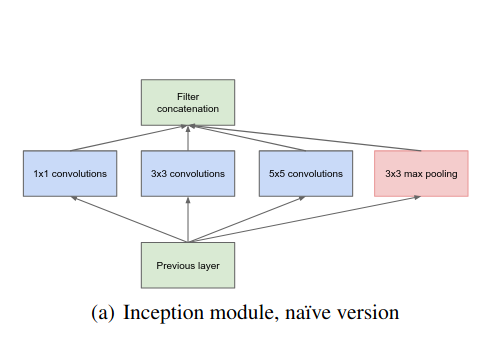

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Chargement du modèle sans la "tête" de classification, et avec des poids pré-entraînés sur ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# On "gèle" les couches du base_model pour conserver les poids
for layer in base_model.layers:
    layer.trainable = False

# On ajoute nos couches finales

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

#changer pour voir la différence
fine_tune_at = 150
# Geler tout jusqu'à 'fine_tune_at - 1'
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Dégeler à partir de 'fine_tune_at'
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 22,065,955 (84.17 MB)

 Trainable params: 17,629,891 (67.25 MB)

 Non-trainable params: 4,436,064 (16.92 MB)

#Entrainment

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
epochs = 50
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop]
)



# Évaluation finale
final_loss, final_accuracy = model.evaluate(test_generator)
print(f"Précision finale sur le test : {final_accuracy:.2%}")



Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/72 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5950 - loss: 3.4812

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.6328 - loss: 3.3788 - val_accuracy: 0.8862 - val_loss: 2.7001
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 563ms/step - accuracy: 0.8799 - loss: 2.7034 - val_accuracy: 0.8984 - val_loss: 2.5761
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 563ms/step - accuracy: 0.9060 - loss: 2.5690 - val_accuracy: 0.8902 - val_loss: 2.5888
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 85s 591ms/step - accuracy: 0.9367 - loss: 2.4501 - val_accuracy: 0.9146 - val_loss: 2.5457
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 555ms/step - accuracy: 0.9187 - loss: 2.4129 - val_accuracy: 0.9106 - val_loss: 2.3959
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 84s 582ms/step - accuracy: 0.9588 - loss: 2.2360 - val_accuracy: 0.9065 - val_loss: 2.3459
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 565ms/step - accuracy: 0.9677 - loss: 2.1692 - val_accuracy: 0.9146 - val_loss: 2.3466
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 562ms/step - accuracy: 0.9621 - loss: 2.1017 - val_accuracy: 0.9228 

charger le modèle dans un fichier .h5

In [ ]:
from tensorflow.keras.models import load_model

# Charger le modèle sauvegardé
model.save('/content/drive/MyDrive/challenge_rendu_26_janvier/model_inception_v3.h5')
print("Modèle chargé avec succès.")

Modèle chargé avec succès.


#Visualiser les courbes de loss et d’accuracy et la matrice de confusion
Cette section affiche les courbes de précision et de perte pendant l'entraînement et la validation, puis calcule et affiche la matrice de confusion ainsi que le rapport de classification sur le jeu de test.

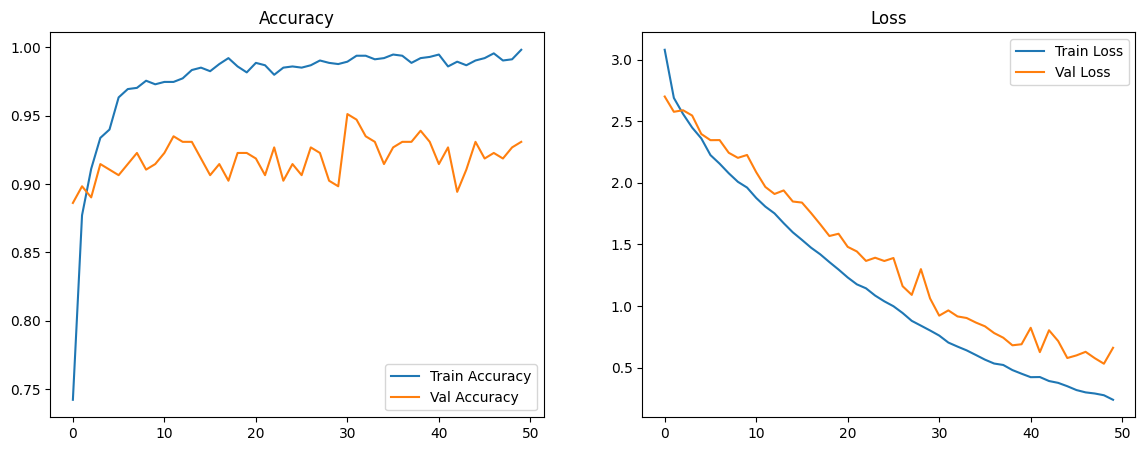

16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 749ms/step


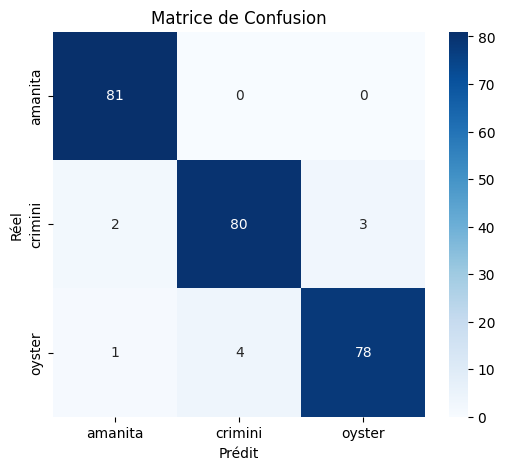

              precision    recall  f1-score   support

     amanita       0.96      1.00      0.98        81
     crimini       0.95      0.94      0.95        85
      oyster       0.96      0.94      0.95        83

    accuracy                           0.96       249
   macro avg       0.96      0.96      0.96       249
weighted avg       0.96      0.96      0.96       249



In [ ]:
###########################################-- Courbes de loss et d’accuracy --###########################################
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

epochs_range = range(len(train_acc))

plt.figure(figsize=(14, 5))

# Courbe d'Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

# Courbe de Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

###############################################-- matrice de confusion --###############################################

plt.show()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1) Prédire sur le jeu de test
pred_probs = model.predict(test_generator)  # Renvoie un tableau de probabilités (batch, nb_classes)
pred_labels = np.argmax(pred_probs, axis=1) # La classe prédite (0, 1, 2, ...)

# 2) Récupérer les labels réels
true_labels = test_generator.classes # Classes réelles associées à chaque image

# 3) Construire la matrice de confusion
cm = confusion_matrix(true_labels, pred_labels)

# 4) Afficher avec seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Rapport de classification
print(classification_report(
    true_labels,
    pred_labels,
    target_names=test_generator.class_indices.keys()
))


# Évaluation des prédictions et affichage des erreurs de classification
Cette section évalue les prédictions du modèle sur l'ensemble de test, calcule le pourcentage de prédictions correctes,
identifie les images mal prédites et les affiche avec leurs étiquettes réelles et prédites.

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step
Pourcentage des classes correctement prédites : 95.98%
Nombre d'images mal prédites : 10
Affichage des premières images mal prédites...


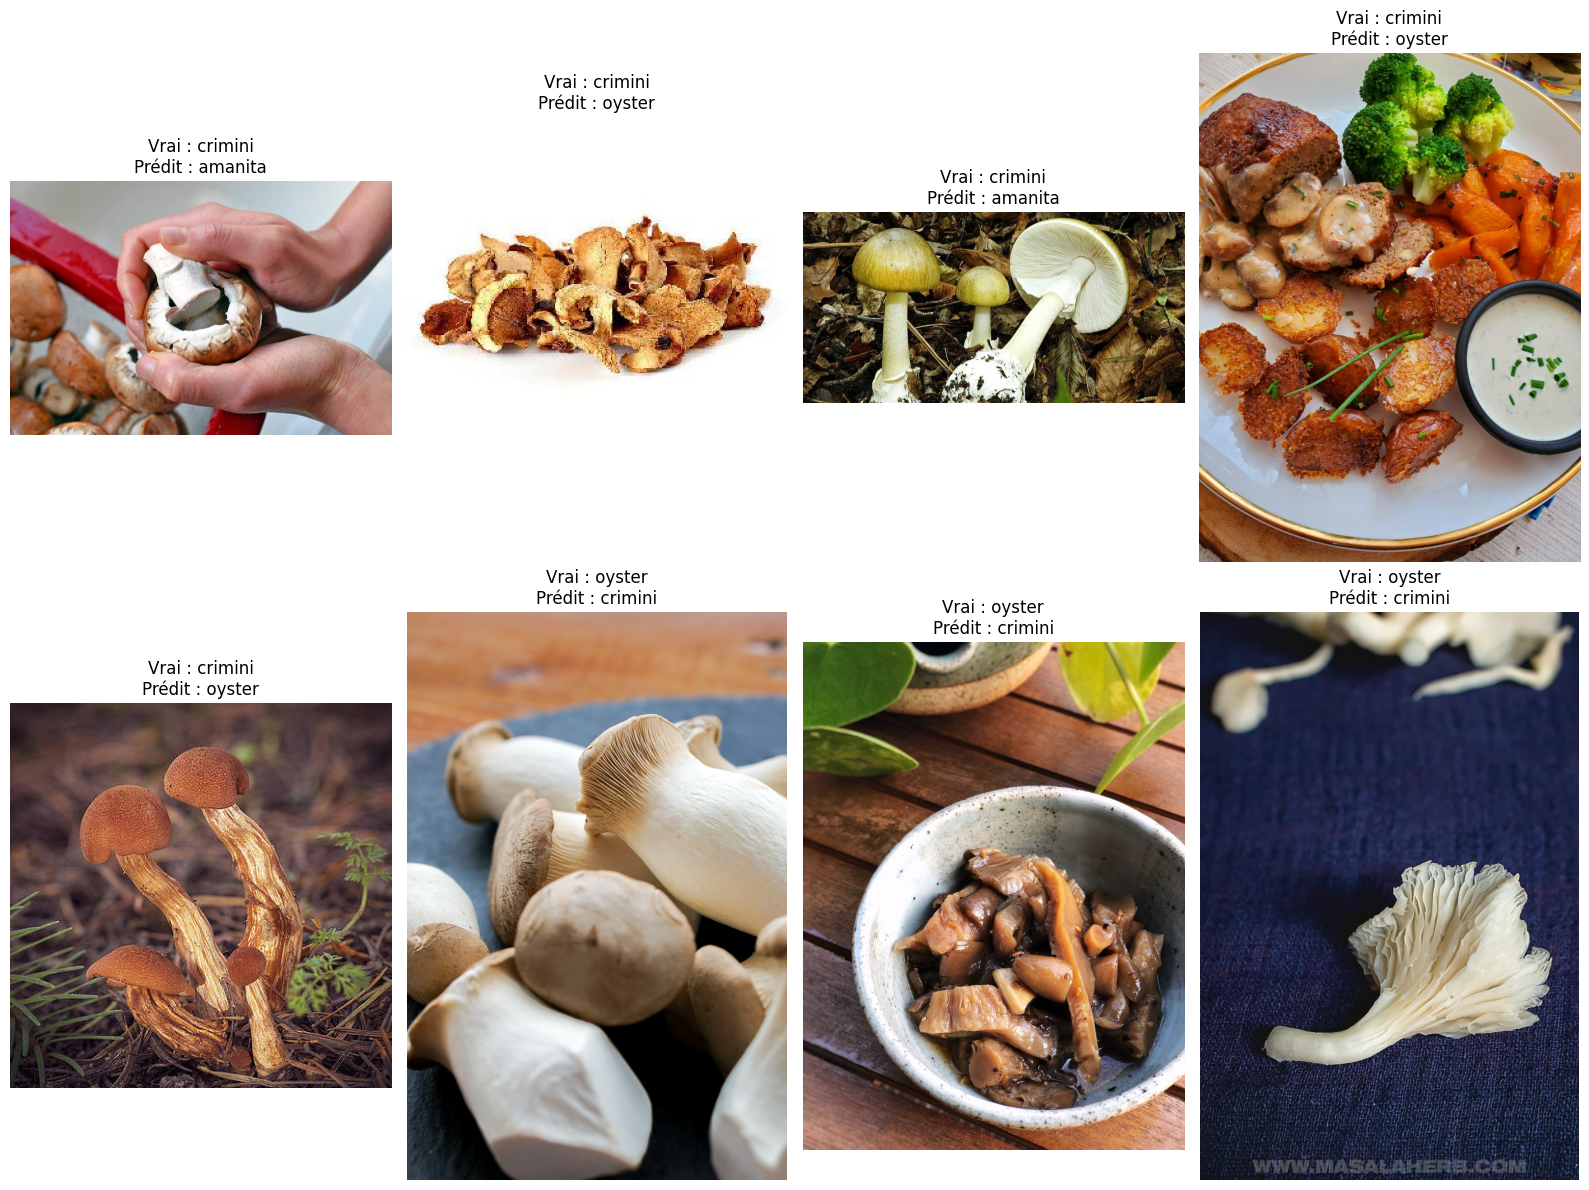

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Obtenez les prédictions sur l'ensemble de test
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculer le pourcentage de classes correctement prédites
correct_predictions = np.sum(predicted_classes == true_classes)
total_predictions = len(true_classes)
accuracy = correct_predictions / total_predictions
print(f"Pourcentage des classes correctement prédites : {accuracy:.2%}")

# Identifier les indices des prédictions incorrectes
incorrect_indices = np.where(predicted_classes != true_classes)[0]

# Afficher les images mal prédites
if len(incorrect_indices) > 0:
    print(f"Nombre d'images mal prédites : {len(incorrect_indices)}")
    print("Affichage des premières images mal prédites...")

    # Définir combien d'images mal prédites afficher
    num_images_to_display = min(len(incorrect_indices), 8)

    plt.figure(figsize=(16, 12))
    for i, idx in enumerate(incorrect_indices[:num_images_to_display]):
        img_path = test_generator.filepaths[idx]
        true_label = class_labels[true_classes[idx]]
        predicted_label = class_labels[predicted_classes[idx]]

        # Chargement de l'image
        image = Image.open(img_path)

        plt.subplot(2, 4, i + 1)
        plt.imshow(image)
        plt.title(f"Vrai : {true_label}\nPrédit : {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Toutes les images ont été correctement prédites !")


# Discussion des Résultats d'inceptionV3

Les résultats obtenus avec le modèle **InceptionV3** nous ont poussés à tester plusieurs paramètres pour optimiser ses performances. Nous avons commencé par analyser les pourcentages de répartition des données afin d’identifier la configuration de split la plus adaptée à notre dataset. Ensuite, nous avons expérimenté avec différentes tailles de batch, en comparant les performances entre des batch sizes de 32 et 16. Enfin, nous avons évalué l’impact du nombre de couches à dégeler dans le modèle (paramètre **fine_tune_at**) en testant plusieurs valeurs : 100, 150, et 200.

Dans la configuration initiale, avec une répartition des données de **70 % pour l’entraînement**, **10 % pour la validation**, et **20 % pour le test**, ainsi qu’un batch size de 32, le modèle a atteint une précision de **91 % sur les données de test** (27 images mal prédites sur 331), **99 % sur l’entraînement**, et **89 % sur la validation**. Cependant, une décroissance non convergente de la loss a été observée, atteignant une valeur de 1.8 pour les ensembles d’entraînement et de validation. Le modèle s’est stabilisé à environ **99 % de précision pour l’entraînement** après 26 époques, bien que l’objectif initial fût de 50 époques.

Dans une deuxième configuration, nous avons ajusté les pourcentages de répartition des données à **70 % pour l’entraînement**, **15 % pour la validation**, et **15 % pour le test**, avec un batch size de 16. Cette configuration a permis d’obtenir une précision améliorée de **95 % sur le test**, **99 % sur l’entraînement**, et **94 % sur la validation** après 50 époques. Cependant, une variante avec un batch size de 32 a donné des résultats légèrement inférieurs, avec une précision de **92 % sur le test**, **99 % sur l’entraînement**, et **91 % sur la validation**.

Enfin, nous avons évalué le paramètre **fine_tune_at** en dégelant différentes profondeurs dans le modèle :
- **fine_tune_at = 100** : Précision de **99 % pour l’entraînement**, **92 % pour la validation**, et **90 % pour le test**, avec 23 images mal prédites sur 249.
- **fine_tune_at = 150** : Précision de **99 % pour l’entraînement**, **93 % pour la validation**, et **95 % pour le test**, avec 10 images mal prédites sur 249.
- **fine_tune_at = 200** : Précision de **98 % pour l’entraînement**, **90 % pour la validation**, et **91 % pour le test**, avec 25 images mal prédites sur 249.

En conclusion, nous avons identifié que la meilleure configuration pour notre modèle est une répartition des données à **70 % pour l’entraînement**, **15 % pour la validation**, et **15 % pour le test**, avec un batch size de 16 et un **fine_tune_at** fixé à 150.


# Le modèle VGG-16

Dans cette section, nous construisons notre modèle en nous basant sur l'architecture du VGG-16. Cependant, cette partie sert principalement à présenter nos essais, car ce modèle sera finalement écarté au profit de l'InceptionV3, qui offre de meilleurs résultats.

Le modèle VGG-16 est un réseau de neurones convolutif conçu pour la classification d'images, caractérisé par une architecture profonde et régulière. Il prend en entrée des images de taille (224, 224, 3) et utilise des blocs de couches convolutives avec des filtres 3×3 et un padding "same" pour conserver les dimensions spatiales. Les blocs incluent des couches avec 64, 128, 256, et 512 filtres, entrecoupées de couches de max-pooling (2×2, stride 2) pour réduire les dimensions. Après la dernière couche de convolution, les caractéristiques sont aplaties en un vecteur de taille 25088, suivi de trois couches entièrement connectées. Les deux premières ont 4096 neurones, et la dernière, avec une activation softmax, génère les probabilités pour 1000 classes d'objets, adaptées au défi ILSVRC.

[GeeksforGeeks, "VGG-16 | CNN model", dernière mise à jour : 21 mars 2024.](https://www.geeksforgeeks.org/vgg-16-cnn-model/)

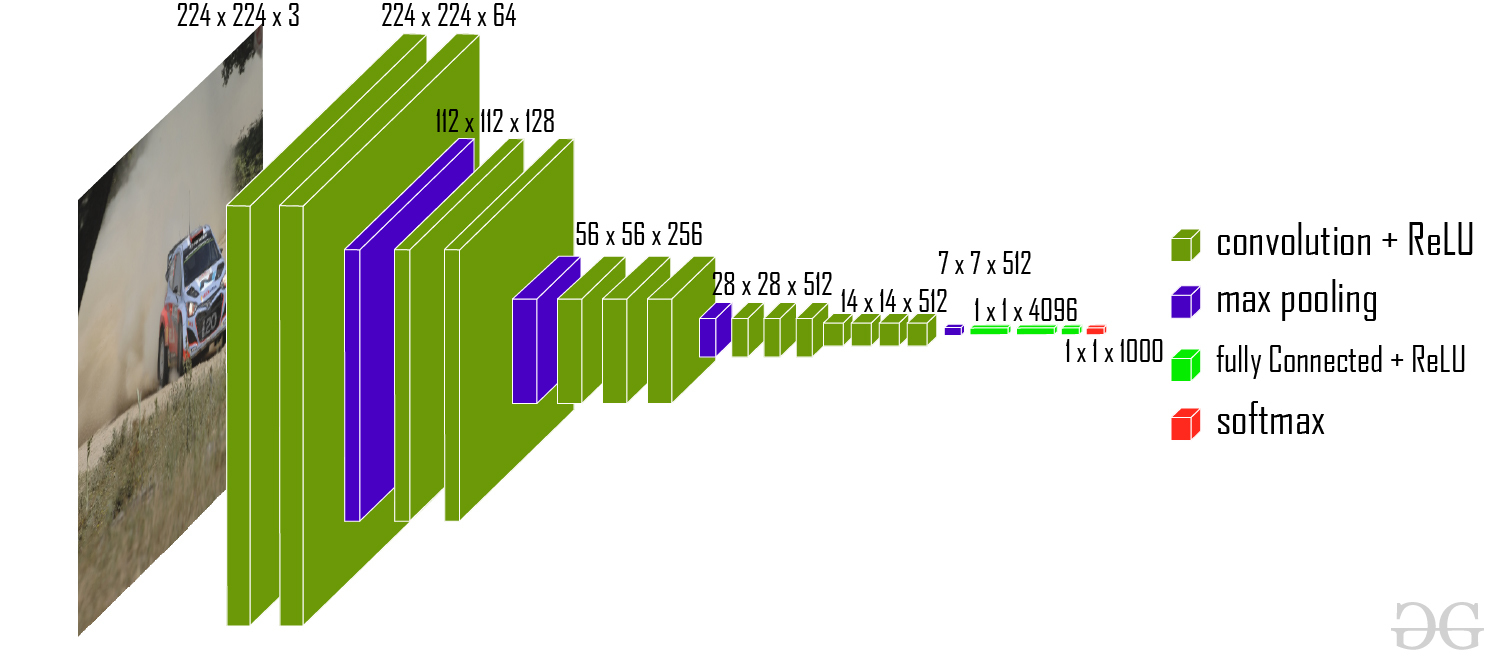

# Bibiliothèques

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Augementation des données

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définissez la taille finale de vos images
# (par ex. 224x224 pour un CNN custom, ou 299x299 pour InceptionV3).
img_size = (224, 224)
batch_size = 16
dossier_split='/content/drive/MyDrive/Colab Notebooks/challenge_rendu_26_janvier/datasets_split'
train_dir = os.path.join(dossier_split, 'train')
val_dir   = os.path.join(dossier_split, 'val')
test_dir  = os.path.join(dossier_split, 'test')

# Data augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Pas de data augmentation pour la validation et test, seulement rescale
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Générateurs
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1148 images belonging to 3 classes.
Found 246 images belonging to 3 classes.
Found 249 images belonging to 3 classes.


# VGG_16 prèentrainé

In [ ]:
# Charger VGG16 sans la “tête” d’origine
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler toutes les couches du “body” de VGG16
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
# x = Flatten()(x)  # Option 1 : Flatten
x = GlobalAveragePooling2D()(x)  # Option 2 : Global Average Pooling
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
fine_tune_at = 11

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │              

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 13,045,251 (49.76 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

# Entrainement

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop]
)


Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 468ms/step - accuracy: 0.7803 - loss: 0.5731 - val_accuracy: 0.8171 - val_loss: 0.6072
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 433ms/step - accuracy: 0.8202 - loss: 0.4499 - val_accuracy: 0.6992 - val_loss: 0.7709
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 434ms/step - accuracy: 0.7867 - loss: 0.5579 - val_accuracy: 0.8496 - val_loss: 0.4611
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 439ms/step - accuracy: 0.8845 - loss: 0.3360 - val_accuracy: 0.8780 - val_loss: 0.3600
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 449ms/step - accuracy: 0.9125 - loss: 0.2933 - val_accuracy: 0.8537 - val_loss: 0.3947
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 438ms/step - accuracy: 0.8972 - loss: 0.3113 - val_accuracy: 0.8415 - val_loss: 0.4535
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 458ms/step - accuracy: 0.9112 - loss: 0.2548 - val_accuracy: 0.8699 - val_loss: 0.4370


# Affichage des tests

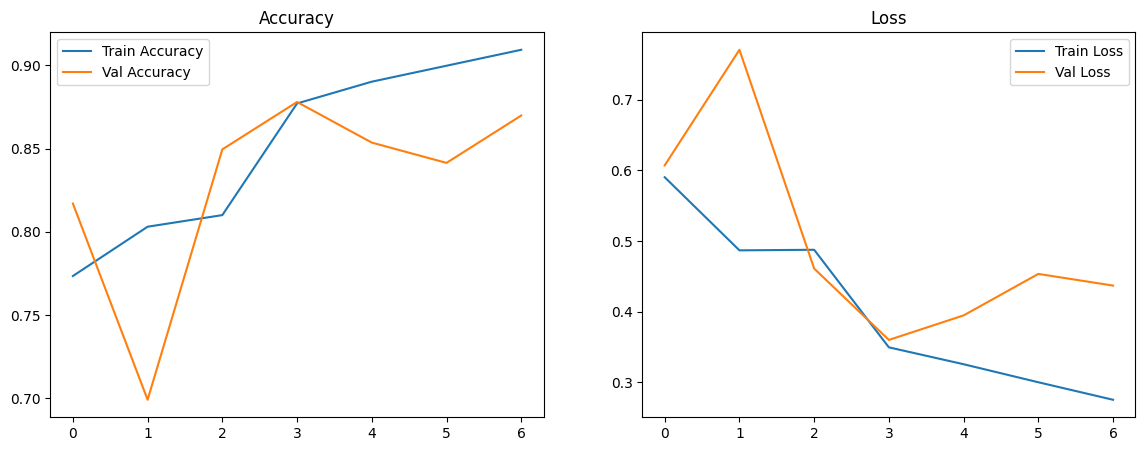

In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

epochs_range = range(len(train_acc))

plt.figure(figsize=(14, 5))

# Courbe d'Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

# Courbe de Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()

# Matrice de confusion

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step


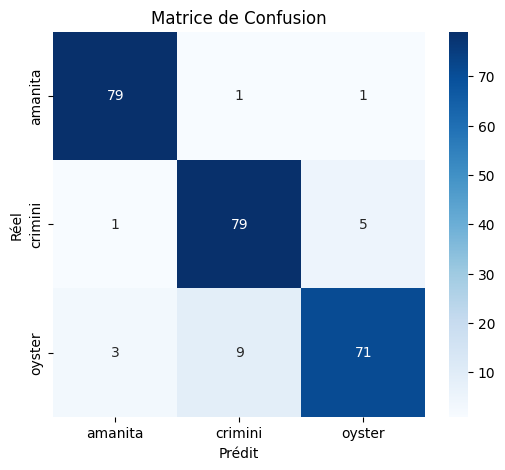

              precision    recall  f1-score   support

     amanita       0.95      0.98      0.96        81
     crimini       0.89      0.93      0.91        85
      oyster       0.92      0.86      0.89        83

    accuracy                           0.92       249
   macro avg       0.92      0.92      0.92       249
weighted avg       0.92      0.92      0.92       249



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import     , classification_report

# 1) Prédire sur le jeu de test
pred_probs = model.predict(test_generator)  # Renvoie un tableau de probabilités (batch, nb_classes)
pred_labels = np.argmax(pred_probs, axis=1) # La classe prédite (0, 1, 2, ...)

# 2) Récupérer les labels réels
true_labels = test_generator.classes        # Classes réelles associées à chaque image

# 3) Construire la matrice de confusion
cm = confusion_matrix(true_labels, pred_labels)

# 4) Afficher avec seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# (Optionnel) Rapport de classification
print(classification_report(
    true_labels,
    pred_labels,
    target_names=test_generator.class_indices.keys()
))